# Running MAGIC and PHATE on Immunometabolism dataset
**Author:** Scott Campit

# Summary
This notebook performs data imputation using MAGIC for single-cell COBRA analyses.

To visualize the results, we will use PHATE, which was also developed in the same lab.

In [1]:
#!pip install --user magic-impute
#!pip install --user phate
import magic
import phate
import scprep

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Read excel files
import xlrd
import openpyxl
from openpyxl import load_workbook

import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

c:\users\scott\envs\python\immune\scripts\python.exe
3.9.0 (tags/v3.9.0:9cf6752, Oct  5 2020, 15:23:07) [MSC v.1927 32 bit (Intel)]
sys.version_info(major=3, minor=9, micro=0, releaselevel='final', serial=0)


# 1. Import data
First, let's import the immunometabolism data. I saved the data as an excel file where each sheet is a different cell lineage. The rows correspond to individual genes. The columns correspond to different time points.

In [2]:
# Read in count matrix
datapath = r"C:\Users\scott\Data\scRNASeq\shea\celldf.xlsx"
wb = load_workbook(filename=datapath, read_only=True)
print(wb.sheetnames)

['Stromal', 'AlveolarMacrophages', 'Macrophages', 'Monocytes', 'Pneumocytes', 'Bcells', 'Granulocytes', 'Tcells', 'Dendritic', 'Neutrophils', 'NK', 'Endothelial', 'HSC']


# 2. Analyze Neutrophil data specifically
Let's write up some code to preprocess the dataset. We'll analyze the Neutrophil dataset first, because that's the main dataset of interest.

In [3]:
counts = pd.read_excel(datapath, 
                       sheet_name=wb.sheetnames[10])

First, let's grab the metadata we need.

In [4]:
# Drop symbols
symbols = counts["Symbol"]
counts = counts.drop("Symbol", axis=1)

# Grab cell names
celltype = counts.columns

Then let's print the resulting dataframe.

In [5]:
print(counts.head())

   NK Cells  0  NK Cells  0.1  NK Cells  0.2  NK Cells  0.3  NK Cells  0.4  \
0            0              0              0              0              0   
1            0              0              0              0              0   
2            0              0              0              0              0   
3            0              0              0              0              0   
4            0              0              0              0              0   

   NK Cells  0.5  NK Cells  0.6  NK Cells  0.7  NK Cells  0.8  NK Cells  0.9  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   ...  NK Cells  14.13  NK Cells  14.14  NK Cells

The data is current arranged where the rows are genes and the columns are cell lines. Let's transpose the matrix so that columns are genes and rows are cell lines.

In [6]:
counts = counts.transpose()
counts = counts.reset_index()
counts = counts.drop('index', axis=1)

Set the columns to be gene symbols

In [7]:
counts.columns = symbols
counts.index = celltype
print(counts.head())

Symbol         0610007P14Rik  0610009B22Rik  0610009D07Rik  0610009E02Rik  \
NK Cells  0                0              0              0              0   
NK Cells  0.1              0              0              0              0   
NK Cells  0.2              0              0              0              0   
NK Cells  0.3              0              0              0              0   
NK Cells  0.4              0              0              0              0   

Symbol         0610009L18Rik  0610009O20Rik  0610010F05Rik  0610010K14Rik  \
NK Cells  0                0              0              0              0   
NK Cells  0.1              0              0              0              0   
NK Cells  0.2              0              0              0              0   
NK Cells  0.3              0              0              0              0   
NK Cells  0.4              0              0              0              0   

Symbol         0610011F06Rik  0610030E20Rik  ...  Gm8226  Gm996  Ighg1  \


# 2. Data Preprocessing on a Single Cell Lineage
Let's now perform some data filtering.

## 2a. Filtering by library size
The library size of a cell is the number of unique mRNA molecules in the cell. As an arbitrary threshold, we will remove all cells that have fewer than 500 reads per cell.

<AxesSubplot:xlabel='Library size', ylabel='Number of cells'>

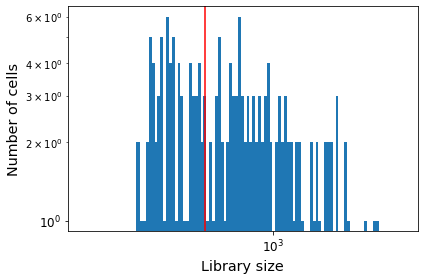

In [8]:
scprep.plot.plot_library_size(data=counts,
                              cutoff=500)

<AxesSubplot:xlabel='Library size', ylabel='Number of cells'>

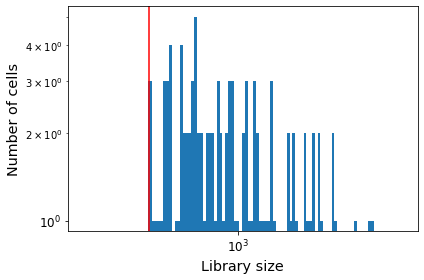

In [9]:
# be sure to uncomment this, unless your data is pre-filtered
counts = scprep.filter.filter_library_size(counts, cutoff=500)
scprep.plot.plot_library_size(data=counts,
                              cutoff=500)

## 2b. Filtering lowly expressed genes
Now let's filter lowly expressed genes. First, we'll get a count of the number of genes that are expressed in each cell.

In [10]:
genes_per_cell = np.sum(counts > 0, axis=0)

Then, let's visualize the data. There are several genes showing very little expression. We'll remove rarely-expressed genes.

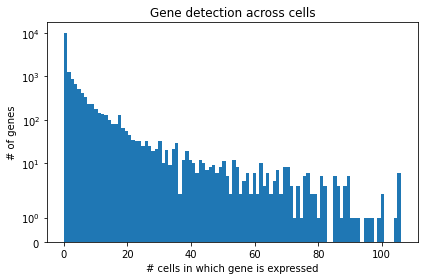

In [11]:
fig, ax = plt.subplots(1, figsize=(6,4))
ax.hist(genes_per_cell, bins=100)
ax.set_xlabel('# cells in which gene is expressed')
ax.set_ylabel('# of genes')
ax.set_yscale('symlog')
ax.set_title('Gene detection across cells')
fig.tight_layout()

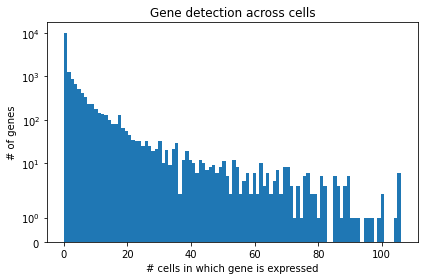

In [12]:
counts = scprep.filter.remove_rare_genes(counts, cutoff=0, min_cells=5)
fig, ax = plt.subplots(1, figsize=(6,4))
ax.hist(genes_per_cell, bins=100)
ax.set_xlabel('# cells in which gene is expressed')
ax.set_ylabel('# of genes')
ax.set_yscale('symlog')
ax.set_title('Gene detection across cells')
fig.tight_layout()

## 2c. Data normalization
Now let's normalize the data. First, we'll normalize the data by library size.

In [13]:
counts = scprep.normalize.library_size_normalize(counts)

Then we'll transform the data using the square root.

<AxesSubplot:xlabel='Library size', ylabel='Number of cells'>

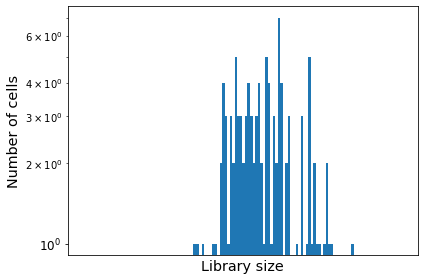

In [14]:
counts = scprep.transform.sqrt(counts)
scprep.plot.plot_library_size(data=counts)

# 3. Run MAGIC on a Single Cell Lineage
Now let's run MAGIC for data imputation with the normalized and filtered data.

In [15]:
magic_op = magic.MAGIC()
nk_magic = magic_op.fit_transform(counts, genes="all_genes")

Calculating MAGIC...
  Running MAGIC on 106 cells and 3492 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.13 seconds.
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.15 seconds.
  Calculating imputation...
Calculated MAGIC in 0.16 seconds.


We can visualize the distribution of the imputed data.

<AxesSubplot:xlabel='Library size', ylabel='Number of cells'>

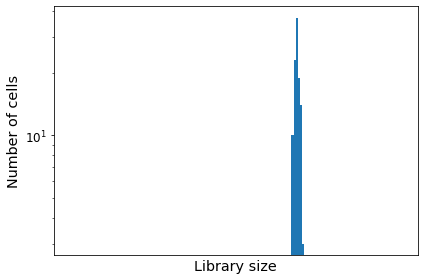

In [16]:
scprep.plot.plot_library_size(data=nk_magic)

In [17]:
import seaborn as sns

In [25]:
nk_magic = nk_magic.round(decimals=4)
print(nk_magic)

Symbol           0610007P14Rik  0610009D07Rik  0610010F05Rik  0610030E20Rik  \
NK Cells  0.9           0.2018         0.3614         0.1886         0.3825   
NK Cells  0.10          0.1679         0.3199         0.2026         0.3944   
NK Cells  0.11          0.1686         0.3312         0.2006         0.3933   
NK Cells  0.15          0.1864         0.3311         0.2134         0.3993   
NK Cells  7             0.1826         0.3343         0.2241         0.4847   
...                        ...            ...            ...            ...   
NK Cells  14.18         0.1651         0.3265         0.1979         0.3926   
NK Cells  14.19         0.1839         0.2947         0.1993         0.3949   
NK Cells  14.20         0.1704         0.3128         0.2131         0.3961   
NK Cells  14.21         0.1739         0.3247         0.2111         0.3716   
NK Cells  14.22         0.1660         0.4223         0.1966         0.3797   

Symbol           0610031J06Rik  0610037L13Rik  1100

Now let's make a heatmap of the data

<AxesSubplot:ylabel='Count'>

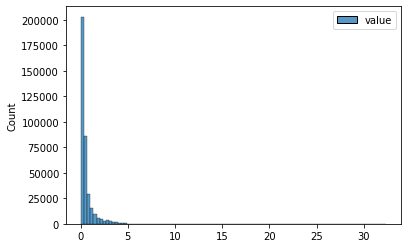

In [19]:
#nk_magic.index = time
sns.histplot(data=pd.melt(nk_magic),
             bins=100)

Now let's transform the normalized data into a robust Z-score and get a p-value out of it. We'll compute gene-wise Z-scores.

In [54]:
from scipy.stats import median_absolute_deviation as mad
mu = nk_magic.median(axis=0)
n = nk_magic.shape[1]
med_abs_dev = mad(nk_magic)
scale_factor = 1.4826
Z = (nk_magic - mu) / (med_abs_dev * scale_factor)
print(Z)

(106, 3492)
Symbol           0610007P14Rik  0610009D07Rik  0610010F05Rik  0610030E20Rik  \
NK Cells  0.9         1.839971       1.413140      -1.338440      -0.366104   
NK Cells  0.10       -0.444828       0.029996      -0.415378       0.274578   
NK Cells  0.11       -0.397649       0.406611      -0.547244       0.215355   
NK Cells  0.15        0.802038       0.403278       0.296699       0.538388   
NK Cells  7           0.545925       0.509930       1.002182       5.136221   
...                        ...            ...            ...            ...   
NK Cells  14.18      -0.633543       0.249966      -0.725263       0.177668   
NK Cells  14.19       0.633543      -0.809889      -0.632957       0.301497   
NK Cells  14.20      -0.276333      -0.206638       0.276919       0.366104   
NK Cells  14.21      -0.040439       0.189974       0.145053      -0.952947   
NK Cells  14.22      -0.572885       3.442863      -0.810976      -0.516852   

Symbol           0610031J06Rik  0610037

Now let's plot the resulting distribution from taking the Z-score.

<AxesSubplot:ylabel='Count'>

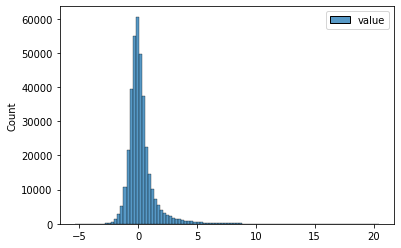

In [57]:
sns.histplot(data=pd.melt(Z),
             bins=100)

(106, 3492)


<AxesSubplot:ylabel='Count'>

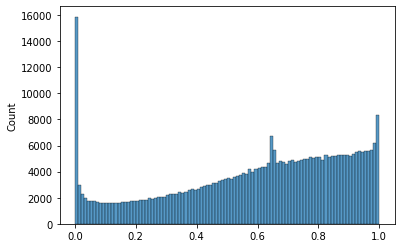

In [65]:
from scipy.stats import norm
pval = norm.sf(abs(Z))*2 
print(pval.shape)
sns.histplot(data=pval.flatten(),
             bins=100)


In [66]:
pval = pd.DataFrame(pval,
                    index=nk_magic.index,
                    columns=nk_magic.columns)

# 4. Run PHATE
Now let's perform dimension reduction.

Calculating PHATE...
  Running PHATE on 106 observations and 3492 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.29 seconds.
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.30 seconds.
  Calculating optimal t...
    Automatically selected t = 12
  Calculated optimal t in 0.01 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.33 seconds.


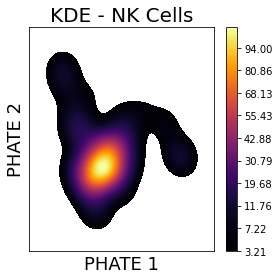

In [69]:
phate_op = phate.PHATE()
nk_phate = phate_op.fit_transform(nk_magic)

import seaborn as sns

fig, ax = plt.subplots(1, figsize=(4,4))
sns.kdeplot(nk_phate[:,0], 
            nk_phate[:,1], 
            n_levels=100, 
            shade=True, 
            cmap='inferno', 
            zorder=0, 
            ax=ax,
            cbar=True)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel('PHATE 1', fontsize=18)
ax.set_ylabel('PHATE 2', fontsize=18)

ax.set_title('KDE - NK Cells', fontsize=20)

fig.tight_layout()



# 4. Create a Function That Performs MAGIC Imputation for All Cell Types
Now that we have walked through the steps of a single lineage and found that the data distribution appears more "Normal", we can repeat this for all immune cell types. 

First, let's define a function to compute some robust standardized data using the robust Z-score method.

In [ ]:
from scipy.stats import median_absolute_deviation as mad
from scipy.stats import norm

def robust_zscore(df):
    """
    robust_zscore computes a modified version of the Z-score centered around the media and scaled by the median absolute deviation.
    INPUT:
      :param df: A data frame corresponding to numerical values where rows correspond to cells and columns correspond to genes.
    OUTPUTS:
      :output Z: A data frame of the robust Z-scores.
      :output pval: A data frame of the p-values corresponding to the robust Z-scores.

    """
    # Compute model parameters
    mu = df.median(axis=0)
    n = df.shape[1]
    med_abs_dev = mad(df)
    scale_factor = 1.4826

    # Compute robust Z-score
    Z = (df - mu) / (med_abs_dev * scale_factor)

    # Compute P-value based on Z-score
    pval = norm.sf(abs(Z))*2 
    pval = pd.DataFrame(pval,
                    index=df.index,
                    columns=df.columns)
    return(Z, pval)

Next, we'll define a function that runs the MAGIC pipeline described above.

In [9]:
def MAGIC_pipeline(df):
    """
    MAGIC_pipeline performs data preprocessing, MAGIC imputation, and data standardization.
    INPUT: 
      :param df: A pandas dataframe of the raw counts data.
    OUTPUT:
      :param Z: A pandas dataframe of the Z-scores that reach a p-value threshold less than 0.05.
    """
    # Drop symbols
    symbols = df["Symbol"]
    df = df.drop("Symbol", axis=1)

    # Grab cell names
    celltype = df.columns

    # Annotate and configure data
    df = df.transpose()
    df = df.reset_index()
    df = df.drop('index', axis=1)
    df.columns = symbols
    df.index = celltype

    # Perform some data filtering
    df = scprep.filter.filter_library_size(df, cutoff=500)
    df = scprep.filter.remove_rare_genes(df, cutoff=0, min_cells=5)

    # Perform count normalization and square root transformation.
    df = scprep.normalize.library_size_normalize(df)
    df = scprep.transform.sqrt(df)

    # Data imputation with MAGIC
    magic_op = magic.MAGIC()
    magic_data = magic_op.fit_transform(df, genes="all_genes")
    magic_data = magic_data.round(decimals=4)

    # Compute Z-scores
    Z, pvalue = robust_zscore(magic_data)
    Z[pvalue > 0.05] = np.NaN

    return(Z)

Finally, let's iterate this pipeline across all cell types. I ended up having to delete the cache for memory intensive purposes.

In [3]:
for celltypes in wb.sheetnames: 
    counts = pd.read_excel(datapath, 
                        sheet_name=celltypes)
    Z = MAGIC_pipeline(counts)
    del counts

    Z.to_csv('C:/Users/scott/Analysis/Immune/'+celltypes+'_magic.csv')
    del Z



NameError: name 'MAGIC_pipeline' is not defined